In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
from scipy.stats import norm, kstest, sem, ttest_ind, linregress, ttest_ind_from_stats, ttest_1samp
import matplotlib.pyplot as plt


In [3]:
# load trace files from the following directory: C:\Users\jjudge3\Desktop\Data\crossing_PPR\sagittal_L4_NBQX\01-15-25\selected_zda\01_02_01_latency_map
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/sagittal_L4_NBQX/01-15-25/selected_zda/01_02_01_latency_map/"
data_dir_ladders = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/sagittal_L4_NBQX/01-15-25/selected_zda/01_02_01_extra_ladders/"
output_fig_dir = 'P:/John/crossing-paper/input/'

if os.name == 'posix':  # local Linux path
    data_dir = data_dir.replace("C:/Users/jjudge3/Desktop/Data/crossing_PPR", "/home/john")
    data_dir_ladders = data_dir_ladders.replace("C:/Users/jjudge3/Desktop/Data/crossing_PPR", "/home/john")
    output_fig_dir = '/home/john/crossing-paper/input/'

export_summary = data_dir + "export_summary_backup.csv"
ladder_exp_summary = data_dir_ladders + "export_summary_backup.csv"
rli_png = data_dir + "rli.png"

# read in png
rli_img = cv2.imread(rli_png)

# downsample rli_img to 80x80
rli_img = cv2.resize(rli_img, (80, 80))


lat_df = pd.read_csv(export_summary)
ladder_df = pd.read_csv(ladder_exp_summary)

# what is min and max of X_Center and Y_Center?
min_x, max_x = int(lat_df['X_Center'].min()), int(lat_df['X_Center'].max())
min_y, max_y = int(lat_df['Y_Center'].min()), int(lat_df['Y_Center'].max())

# crop
rli_img = rli_img[min_y:max_y, min_x:max_x]

um_per_px = 6.0 #um
lat_df['X_Center'] = lat_df['X_Center'] * um_per_px
lat_df['Y_Center'] = lat_df['Y_Center'] * um_per_px

stim_time = 48.6
lat_df['latency'] = lat_df['latency'] - stim_time
ladder_df['latency'] = ladder_df['latency'] - stim_time

# To lat_df, at a point at (0, 0) and (80, 80) to control output size of pivot

lat_df

,ROI,amp,latency,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording
0,1,2.120360,2.6322,168.0,150.0,1_rois_output__rand_0,1-15-25,1,2,1
1,2,2.677490,2.9154,198.0,96.0,1_rois_output__rand_0,1-15-25,1,2,1
2,3,1.357770,2.3229,246.0,192.0,1_rois_output__rand_0,1-15-25,1,2,1
3,4,1.963650,2.3392,204.0,216.0,1_rois_output__rand_0,1-15-25,1,2,1
4,5,1.628480,2.3123,246.0,204.0,1_rois_output__rand_0,1-15-25,1,2,1
...,...,...,...,...,...,...,...,...,...,...
395,96,0.684941,3.9149,462.0,210.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1
396,97,0.698349,2.9695,462.0,294.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1
397,98,0.620905,2.6468,444.0,282.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1
398,99,0.723235,3.1076,456.0,294.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1


(63, 59)


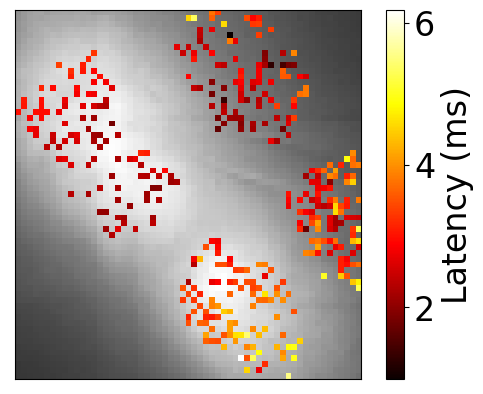

In [13]:
plt.rcParams.update({'font.size': 24})
lat_df = lat_df[lat_df['latency'] < (55-stim_time)]

# create a 2d heatmap of the latency data
#latency_heatmap = lat_df[['X_Center', 'Y_Center', 'latency']].pivot(columns=["Y_Center", "X_Center", "latency"])

# rewrite pivot with keyword arguments
latency_heatmap = lat_df.pivot(index='Y_Center', columns='X_Center', values='latency')

# fill nan with 0
latency_heatmap = np.nan_to_num(latency_heatmap)


# blur the heatmap to make it more continuous, using 2-d Gaussian filtering, but rescale to original [min, max] range
'''min_lat = latency_heatmap.min()
max_lat = latency_heatmap.max()
latency_heatmap = cv2.GaussianBlur(latency_heatmap, (7,7), 0)
latency_heatmap = (latency_heatmap - latency_heatmap.min()) / (latency_heatmap.max() - latency_heatmap.min()) * (max_lat - min_lat) + min_lat
'''
# turn zeros in latency heatmap to nan
latency_heatmap[latency_heatmap < 0.3] = np.nan

# mask out rli_img where latency heatmap is not nan

print(latency_heatmap.shape)

# colorscale lim from 1 to 6.5
latency_heatmap = np.clip(latency_heatmap, 0, 6.5)
plt.imshow(rli_img)
plt.imshow(latency_heatmap, cmap='hot', interpolation='nearest')
plt.colorbar(label='Latency (ms)')
#plt.xlabel('Axis 1 (μm)')
#plt.ylabel('Axis 2 (μm)')

# set x and y ticks to their value times um_per_px
plt.xticks([]) #ticks=[100/6, 200/6, 300/6], labels=[100, 200, 300])
plt.yticks([]) #ticks=[100/6, 200/6, 300/6], labels=[100, 200, 300])

plt.savefig(output_fig_dir + 'latency_heatmap.png')
plt.show()


(63, 59)


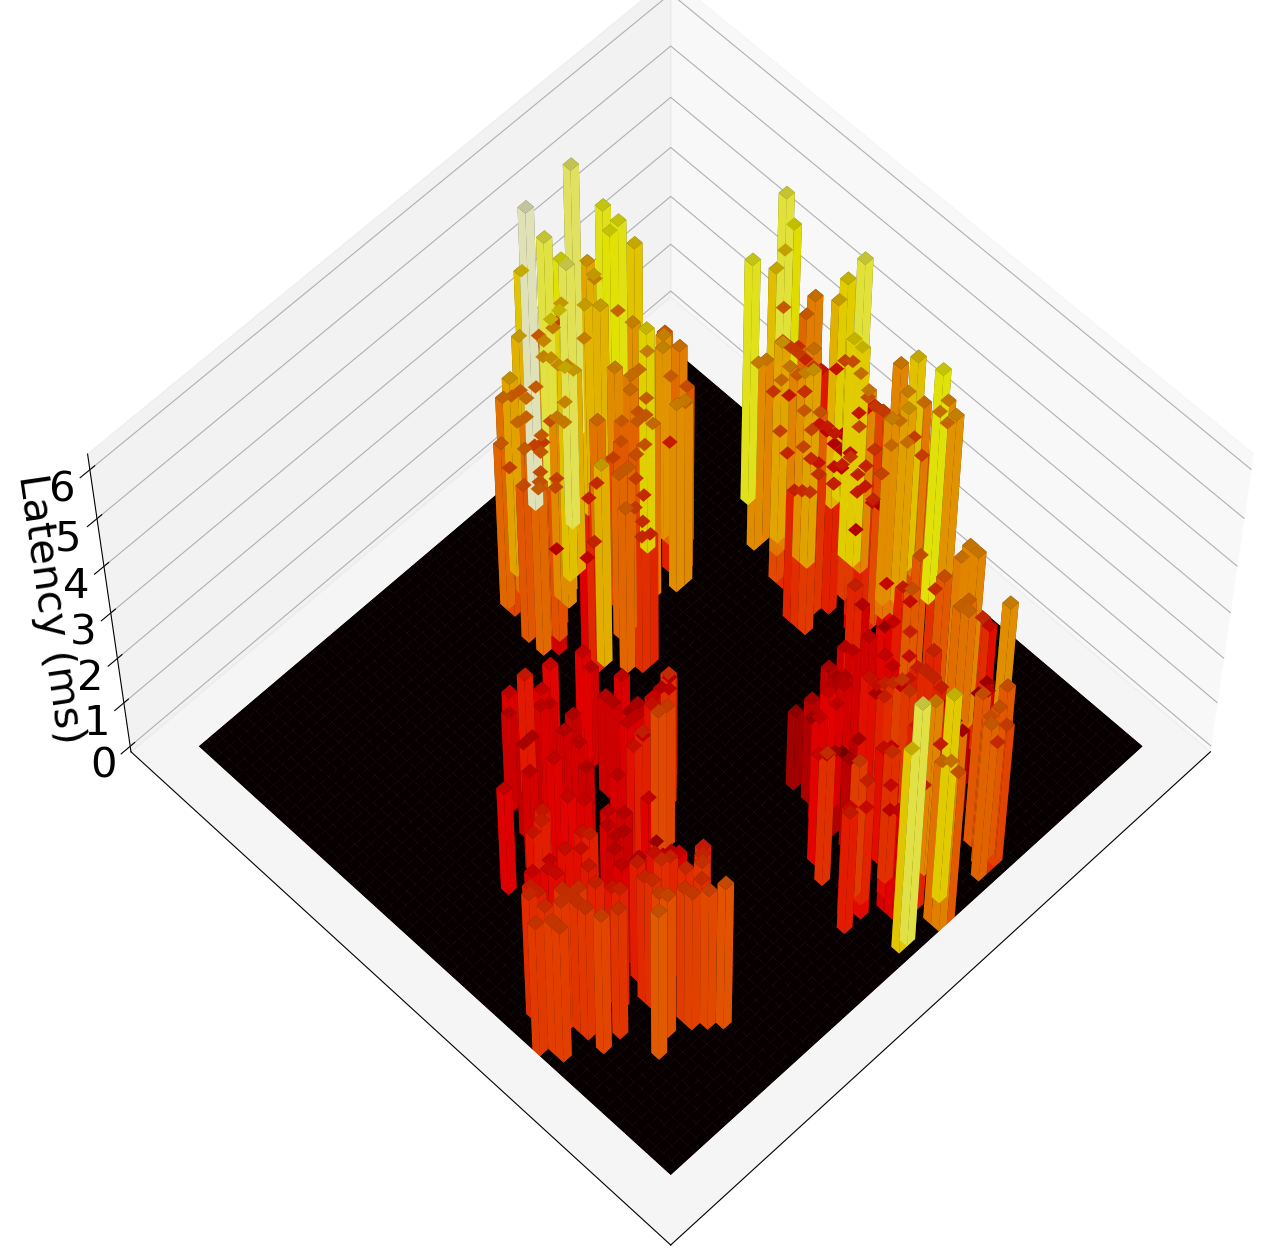

In [5]:
# make this a 3-d bar plot where the bars are colored by their height

plt.rcParams.update({'font.size': 30})

# filter latency mismeasurements (1-2 outliers)
lat_df = lat_df[lat_df['latency'] < (55-stim_time)]

# create a 2d heatmap of the latency data
#latency_heatmap = lat_df.pivot("Y_Center", "X_Center", "latency")

# with keyword arguments
latency_heatmap = lat_df.pivot(index='Y_Center', columns='X_Center', values='latency')

# fill nan with 0
latency_heatmap = np.nan_to_num(latency_heatmap)

print(latency_heatmap.shape)

# colorscale lim from 1 to 6.5
latency_heatmap = np.clip(latency_heatmap, 0, 6.5)


fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')
x = np.arange(latency_heatmap.shape[1])
y = np.arange(latency_heatmap.shape[0])
x, y = np.meshgrid(x, y)
colors = plt.cm.hot(latency_heatmap.flatten() / 6.5)  # Normalize and apply colormap
# angle of view elevation increase
ax.view_init(elev=60, azim=-135)
ax.bar3d(x.flatten(), y.flatten(), np.zeros_like(latency_heatmap.flatten()), 1, 1, latency_heatmap.flatten(), shade=True, color=colors)
#ax.set_xlabel('Axis 1 (μm)')
#ax.set_ylabel('Axis 2 (μm)')
ax.set_zlabel('Latency (ms)')
# set x and y ticks to their value times um_per_px
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(output_fig_dir + "latency_heatmap_3d.png", dpi=300)

plt.show()


In [6]:
ladder_df['ladder_set'] = 'L4-ladder'
# fill NaN values with empty string
ladder_df = ladder_df.fillna('')
for ladder_type in ['L23-ladder', 'home-ladder', 'neighbor-ladder']:
    ladder_df.loc[ladder_df['amp_array'].str.contains(ladder_type), 'ladder_set'] = ladder_type

# distance is from ROI 1
for ladder_type in ['L4-ladder', 'L23-ladder', 'home-ladder', 'neighbor-ladder']:
    ladder_subset = ladder_df[ladder_df['ladder_set'] == ladder_type]
    ladder_subset['distance'] = np.sqrt((ladder_subset['X_Center'] - ladder_subset.iloc[0]['X_Center'])**2 + (ladder_subset['Y_Center'] - ladder_subset.iloc[0]['Y_Center'])**2)
    ladder_df.loc[ladder_subset.index, 'distance'] = ladder_subset['distance'] * um_per_px

ladder_df[ladder_df['ladder_set'] == 'L4-ladder']

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_10588\1628300282.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ladder_subset['distance'] = np.sqrt((ladder_subset['X_Center'] - ladder_subset.iloc[0]['X_Center'])**2 + (ladder_subset['Y_Center'] - ladder_subset.iloc[0]['Y_Center'])**2)


,ROI,latency,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,amp_array,ladder_set,distance
44,1,3.2954,25.352273,13.806818,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,0.000000
45,2,3.1137,27.021739,16.239130,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,17.700774
46,3,2.9751,28.100000,19.000000,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,35.251796
47,4,2.8263,30.768421,20.842105,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,53.271731
48,5,2.6134,31.988764,23.617978,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,71.069453
49,6,2.5827,34.775281,25.337079,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,89.345619
50,7,2.6821,35.925532,28.106383,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,106.704119
51,8,2.7232,38.566667,30.022222,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,125.507543
52,9,2.3924,40.100000,32.533333,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,143.018886
53,10,2.2047,42.118280,34.784946,1_rois_output__ladder_,1/15/2025,1,2,1,,L4-ladder,161.128862


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_10588\3299733153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L4_ladder_subset_['latency_diff'] = L4_ladder_subset_['latency'].diff().abs()


mean +/- sem diff: 0.20618518518518544 +/- 0.03727053849881374


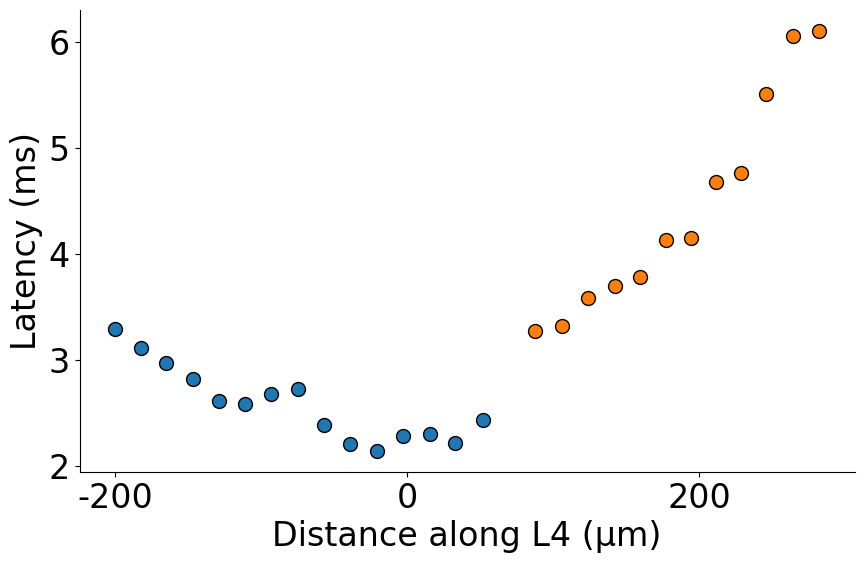

In [23]:
L4_ladder_subset_ = ladder_df[ladder_df['ladder_set'] == 'L4-ladder']
# what are the subsequent differences in latency in the L4 ladder subset?
L4_ladder_subset_['latency_diff'] = L4_ladder_subset_['latency'].diff().abs()
print("mean +/- sem diff:", L4_ladder_subset_['latency_diff'].mean(), "+/-", L4_ladder_subset_['latency_diff'].sem())
home_barrel_subset_ = L4_ladder_subset_[ (L4_ladder_subset_['distance'] < 260)]
neighbor_barrel_subset_ = L4_ladder_subset_[(L4_ladder_subset_['distance'] > 270)]

# plot just of L4 ladder latency vs distance
plt.figure(figsize=(10, 6))
# markersize larger
plt.scatter(home_barrel_subset_['distance'], home_barrel_subset_['latency'], color='tab:blue', edgecolor='k', s=100)
plt.scatter(neighbor_barrel_subset_['distance'], neighbor_barrel_subset_['latency'], color='tab:orange', edgecolor='k', s=100)

# turn off spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(ticks=[0, 200, 400], labels=[-200, 0, 200])

plt.xlabel('Distance along L4 (μm)')
plt.ylabel('Latency (ms)')
plt.show()

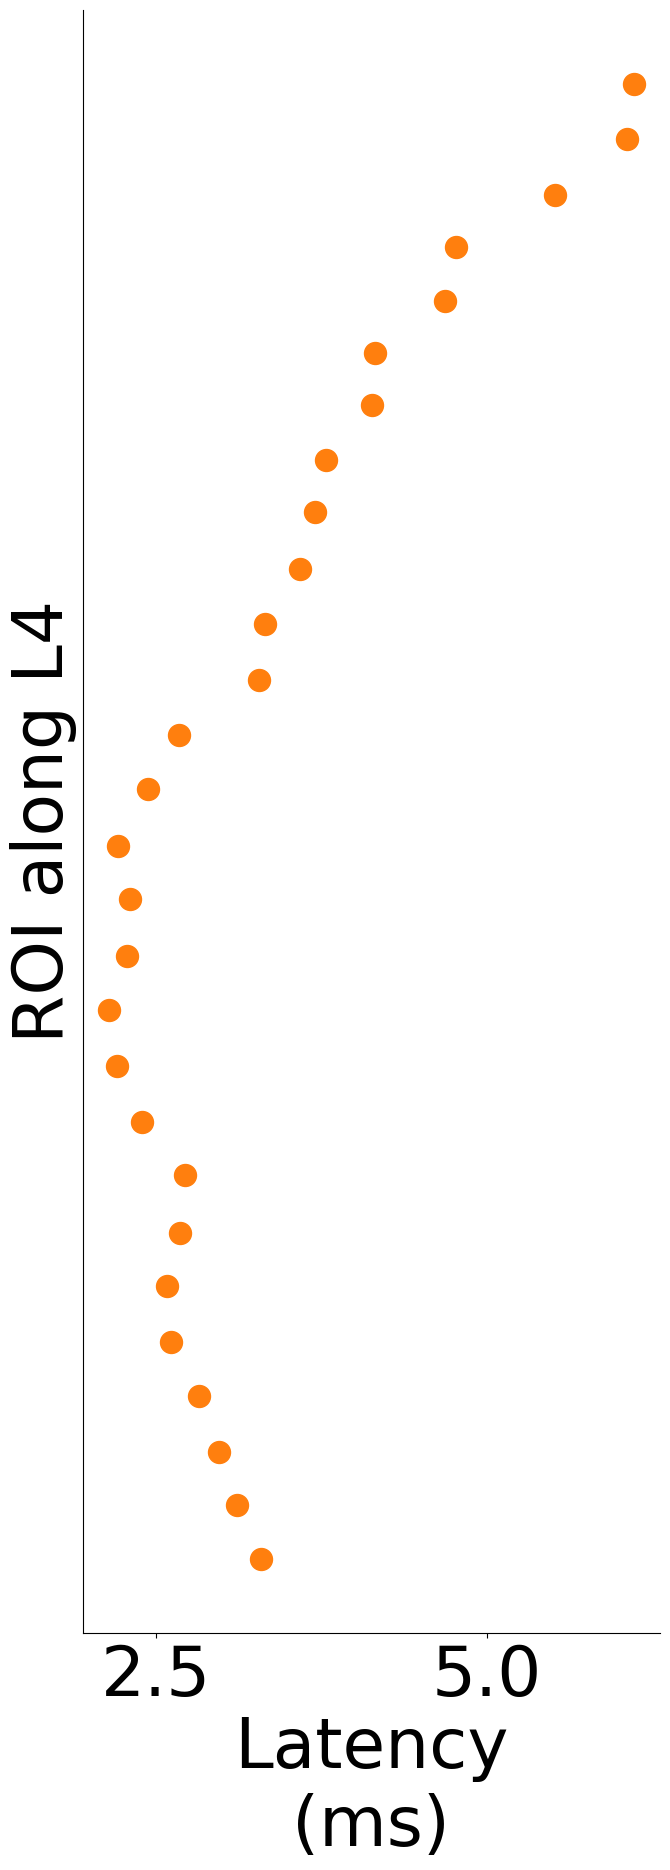

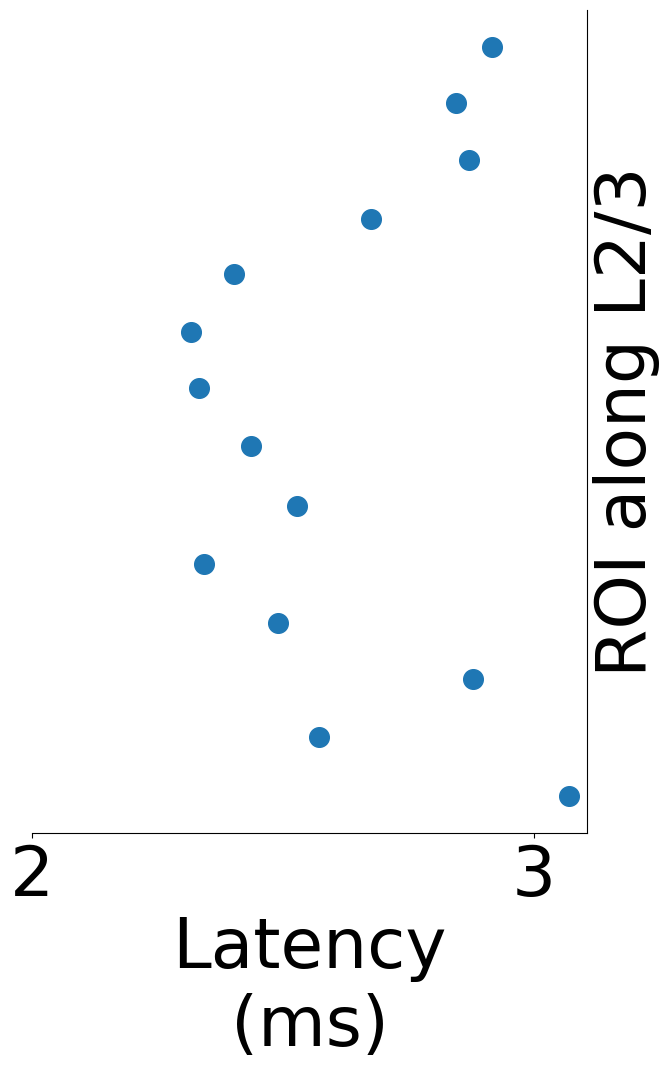

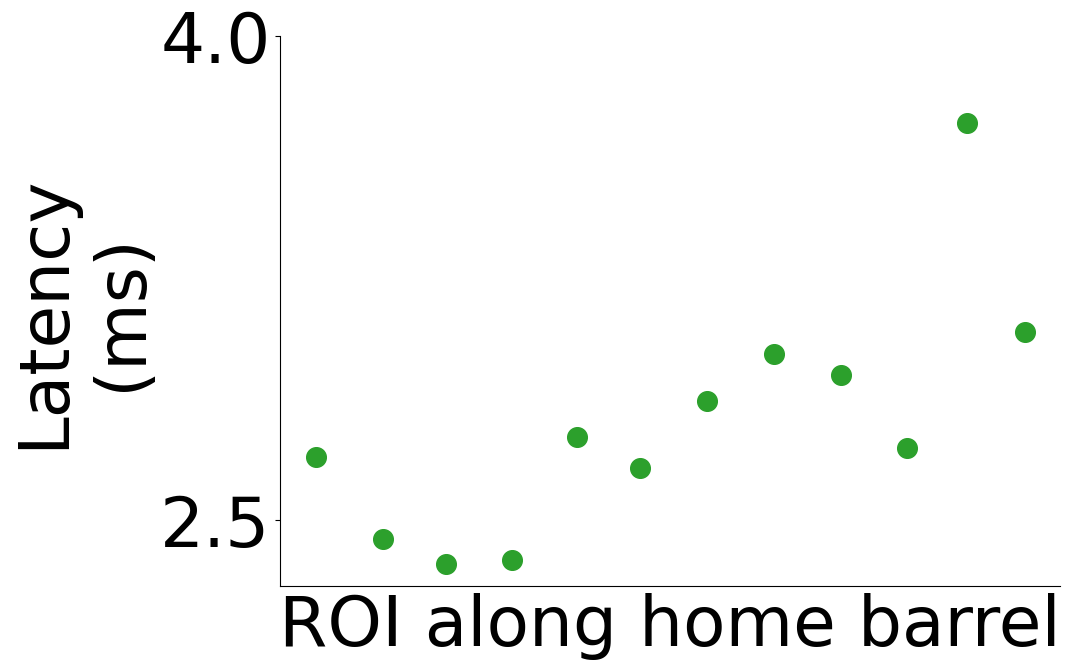

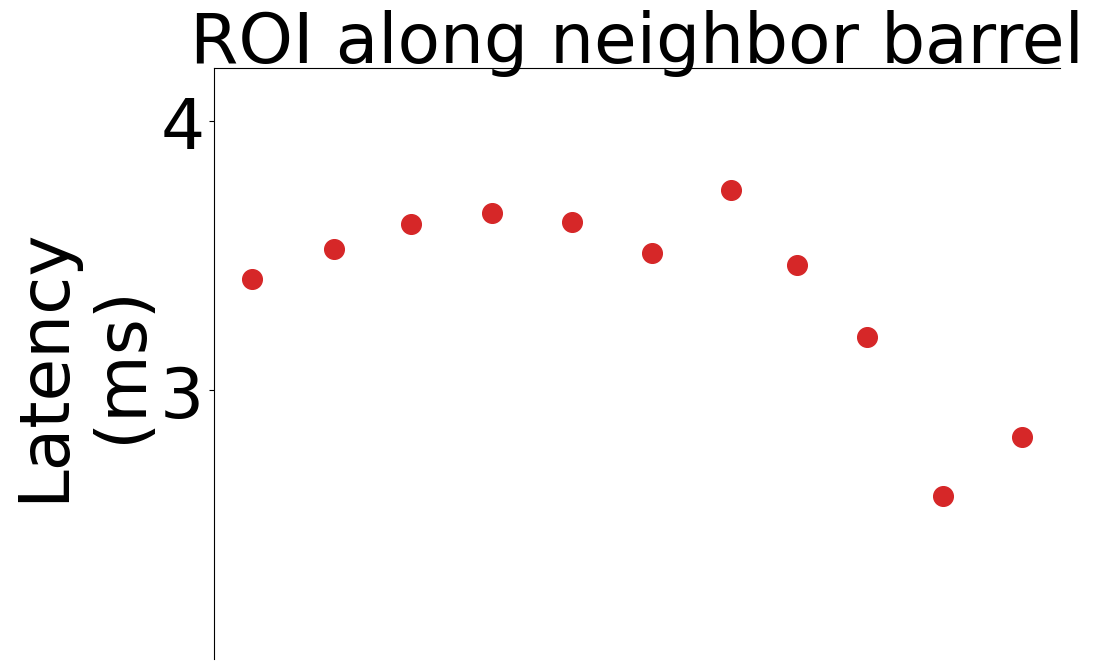

In [7]:
plt.rcParams.update({'font.size': 50})
for i_l, ladder_type in enumerate(['L4-ladder', 'L23-ladder', 'home-ladder', 'neighbor-ladder']):
    color = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red']

    orientation = 'horizontal' if ladder_type in ['home-ladder', 'neighbor-ladder'] else 'vertical'

    ladder_subset = ladder_df[ladder_df['ladder_set'] == ladder_type]
    marker_size = 200 + (50 if ladder_type == 'L4-ladder' else 0)
    
    # set figure size based on orientation
    if orientation == 'horizontal':
        plt.figure(figsize=(12, 8))
        if ladder_type == 'home-ladder':
            ladder_subset = ladder_subset[ladder_subset['ROI'] > 7]
        plt.scatter(ladder_subset['distance'], ladder_subset['latency'], label=ladder_type, color=color[i_l], s=marker_size)
    else:
        plt.figure(figsize=(8, 12 + (8 if ladder_type == 'L4-ladder' else 0)))
        plt.scatter(ladder_subset['latency'], ladder_subset['distance'], label=ladder_type, color=color[i_l], s=marker_size)

    

    if orientation == 'horizontal':
        plt.xlabel(f"ROI along {ladder_type.split('-')[0]} barrel")
        plt.ylabel('Latency\n(ms)')
        #plt.ylim(0, 6.5)
    else:
        plt.ylabel(f"ROI along {ladder_type.split('-')[0].replace('23', '2/3')}")
        plt.xlabel('Latency\n(ms)')
        #plt.xlim(0, 6.5)

    if ladder_type == 'L4-ladder':
        plt.yticks([]) #[0, 200, 400])
        #plt.gca().set_yticklabels([-200, 0, 200])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        #plt.xticks([3, 5])
    elif ladder_type == 'L23-ladder':
        plt.yticks([]) #[0, 100, 200])
        #plt.gca().set_yticklabels([-100, 0, 100])
        plt.gca().yaxis.set_label_position('right')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.xticks([2, 3])
    elif ladder_type == 'home-ladder':
        plt.xticks([]) #[0, 150, 300])
        #plt.gca().set_xticklabels([-150, 0, 150])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.yticks([2.5, 4])
    elif ladder_type == 'neighbor-ladder':
        plt.xticks([]) #([0, 75, 150])
        #plt.gca().set_xticklabels([-75, 0, 75])
        plt.gca().xaxis.set_label_position('top')
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.ylim([2, 4.2])
        plt.yticks([3, 4])

    plt.tight_layout()
    # make it a transparent plot
    plt.savefig(output_fig_dir + 'latency_scatter_' + ladder_type + '.png', dpi=300, transparent=True)
    plt.show()

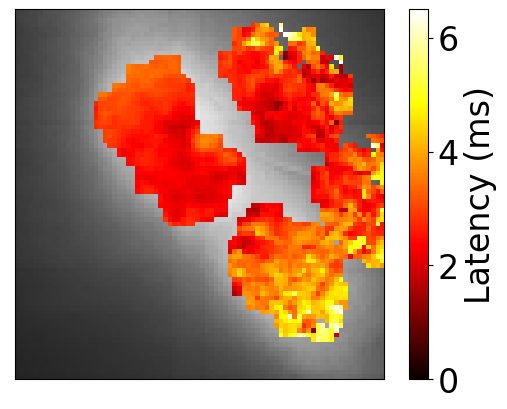

In [56]:

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))


lat_map_arr = read_array_file(data_dir + 'latency_heatmap01_02_01.dat')
lat_map_arr -= stim_time
# any point not included in lat_df should be set to NaN
lat_mask = np.zeros_like(lat_map_arr, dtype=bool)
lat_mask[:, :] = False
color_in_radius = 3
for row in lat_df.iterrows():
    idx = row[0]
    x = int(row[1]['X_Center'] / um_per_px)
    y = int(row[1]['Y_Center'] / um_per_px)
    lat_mask[ y-color_in_radius:y+color_in_radius, x-color_in_radius:x+color_in_radius] = True
lat_map_arr[~lat_mask] = np.nan

# any values < 1 or >7 should be set to NaN
lat_map_arr[(lat_map_arr < 1) | (lat_map_arr > 7)] = np.nan

rli_img = cv2.imread(rli_png)
rli_img = cv2.resize(rli_img, (80, 80))
plt.imshow(rli_img)
plt.imshow(lat_map_arr, cmap='hot', vmin=0, vmax=6.5)

plt.colorbar(label='Latency (ms)')
#plt.xlabel('Axis 1 (μm)')
#plt.ylabel('Axis 2 (μm)')

# set x and y ticks to their value times um_per_px
plt.xticks([]) #ticks=[100/6, 200/6, 300/6], labels=[100, 200, 300])
plt.yticks([]) #ticks=[100/6, 200/6, 300/6], labels=[100, 200, 300])
plt.show()

In [50]:




# To lat_df, at a point at (0, 0) and (80, 80) to control output size of pivot

lat_df

,ROI,amp,latency,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording
0,1,2.120360,2.6322,168.0,150.0,1_rois_output__rand_0,1-15-25,1,2,1
1,2,2.677490,2.9154,198.0,96.0,1_rois_output__rand_0,1-15-25,1,2,1
2,3,1.357770,2.3229,246.0,192.0,1_rois_output__rand_0,1-15-25,1,2,1
3,4,1.963650,2.3392,204.0,216.0,1_rois_output__rand_0,1-15-25,1,2,1
4,5,1.628480,2.3123,246.0,204.0,1_rois_output__rand_0,1-15-25,1,2,1
...,...,...,...,...,...,...,...,...,...,...
395,96,0.684941,3.9149,462.0,210.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1
396,97,0.698349,2.9695,462.0,294.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1
397,98,0.620905,2.6468,444.0,282.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1
398,99,0.723235,3.1076,456.0,294.0,1_rois_supragranular_output__rand_1,1-15-25,1,2,1


## 